## Genetic Algorithm

In [600]:
## Importing libraries
import pandas as pd
import numpy as np
import torch
import re
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

##### Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented and Assignment 1 of this course

### Encoding

In [601]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
# Reading the csv files
df = pd.read_csv('Comp1111_data_csv.csv')
df = df[2:]
df = df.drop(columns=['Regno','ES'])

# Preprocessing
le = preprocessing.LabelEncoder()
df['Tutgroup'] = le.fit_transform(df['Tutgroup'])
df.reset_index(inplace = True)

le = preprocessing.LabelEncoder()
df['Crse/Prog'] = le.fit_transform(df['Crse/Prog'])
df.reset_index(inplace = True)

#Replacing '.' to zeros
df = df.replace(to_replace= '.' , value = 0)

# String to numeric Conversion
df['S'] = pd.to_numeric(df['S'])
df['lab2'] = pd.to_numeric(df['lab2'])
df['Unnamed: 6'] = pd.to_numeric(df['Unnamed: 6'])
df['lab4'] = pd.to_numeric(df['lab4'])
df['Unnamed: 8'] = pd.to_numeric(df['Unnamed: 8'])
df['h2'] = pd.to_numeric(df['h2'])
df['Unnamed: 10'] = pd.to_numeric(df['Unnamed: 10'])
df['p1'] = pd.to_numeric(df['p1'])
df['Unnamed: 12'] = pd.to_numeric(df['Unnamed: 12'])
df['mid'] = pd.to_numeric(df['mid'])
df['Unnamed: 14'] = pd.to_numeric(df['Unnamed: 14'])
df['final'] = pd.to_numeric(df['final'])

X = df.drop(columns = ['final'])
Y = df[['final']]

# Normalization
X['lab2'] = X['lab2'] / 3
X['Unnamed: 6'] = X['Unnamed: 6'] / 5
X['lab4'] = X['lab4'] / 3
X['Unnamed: 8'] = X['Unnamed: 8'] / 20
X['h2'] = X['h2'] / 20
X['Unnamed: 10'] = X['Unnamed: 10'] / 3
X['p1'] = X['p1'] / 20
X['Unnamed: 12'] = X['Unnamed: 12'] / 20
X['mid'] = X['mid'] / 45
X['Unnamed: 14'] = X['Unnamed: 14'] / 3

Y['final'] = Y['final']/100
X = X.drop(columns = ['level_0','index'])

C:\Users\Prateek\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [602]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.2, random_state=42)

X = X_train1.values

Y = Y_train1.values

# Converting dataframes values to tensor
X_train_tensor = torch.Tensor(X_train1.values).float()
Y_train_tensor = torch.Tensor(Y_train1.values).float()

X_test1_tensor = torch.Tensor(X_test1.values).float()
Y_test1_tensor = torch.Tensor(Y_test1.values).float()

### Population selection

In [603]:
def random_initial_population(population_size):
    
    population_array = []
    for i in range(population_size):
        
        # Learning rate range
        learning_rate1 =  np.random.uniform(0.006,0.02)
        # First hidden layer range
        hidden_layer1 = np.random.randint(15,25)
        # Second hidden layer range
        hidden_layer2 = np.random.randint(8,14)
        # Less number of epochs is used because the model converges very ealry which can be seen in the previous assignment picture
        number_of_epochs = np.random.randint(100,250)
        population_array.append((learning_rate1,hidden_layer1,hidden_layer2,number_of_epochs))
    
    return population_array

### Fitness score of population

In [604]:
def fitness(population):
    
    fitness_score_list = []
    for i in population:
        
        learning_rate = i[0] #Extracting the learning rate
        hidden_layers = i[1] #Extracting hidden layers1
        hidden_layers_1 = i[2] #Extracting hidden layers2
        epochs = i[3] #Extracting the number of epochs
        feature_size = X_train1.shape[1]
        
        # Regression model formed
        class Regression_Net(nn.Module):
            def __init__(self,feature_size, hidden, hidden_1,n_output):
                super(Regression_Net, self).__init__()
                self.layer_1 = nn.Linear(feature_size,hidden)
                self.layer_2 = nn.Linear(hidden, hidden_1)
                self.layer_3 = nn.Linear(hidden_1,n_output)
            def forward(self,x):
                fc = self.layer_1(x)
                x = (fc)
                x = (self.layer_2(x))
                output_layer = (self.layer_3(x))
                return output_layer
    
        regression_neural_network = Regression_Net(feature_size,hidden_layers,hidden_layers_1,n_output=1)
        #optimizer
        optimizer = torch.optim.Adam(regression_neural_network.parameters(),lr = learning_rate)
        # Loss function
        loss_function = nn.MSELoss()

        losses_array1 = []

        for ep in range(epochs):
            train_prediction = regression_neural_network(X_train_tensor)

            loss = loss_function(train_prediction,Y_train_tensor)

            losses_array1.append(loss.item()) # Appending the loss to an array
                        
            optimizer.zero_grad()

            loss.backward() # Implementation of back propogation

            optimizer.step() # optimising the model
            
        test_prediction = regression_neural_network(X_test1_tensor)
        loss_on_test_data = loss_function(test_prediction,Y_test1_tensor)

        fitness_score_list.append((i,losses_array1[-1],loss_on_test_data.item())) # Storing the hyperparameters, training loss and testing loss   
        
    return fitness_score_list


### Decimal to binary conversion

In [605]:
## Conversion of decimal to binary number
def decimal_to_binary(number,places):
    
    integer_number = int(number) # Extracting the integer values
    float_number = number - integer_number # Extracting the after decimal values
    binary_int = bin(integer_number) # Converting the integer to binary using the function bin()
    binary_int = binary_int[2:]
    binary_float = ""
    
    # Conversion of the number after the decimal place to binary and then adding both the numbers to get the resultant
    if(float_number != 0):
        while(places):
            float_number = float_number * 2
            if (int(float_number) == 1):
                float_number = float_number - 1
                binary_float += "1"
            else:
                binary_float += "0"
            places = places - 1
        string_binary_int = str(binary_int)
        string_binary_int += '.'
        string_binary_int += binary_float
    else:
        string_binary_int = str(binary_int)

                
    return string_binary_int

### Binary to decimal conversion

In [606]:
# Conversion of binary to decimal 
def binary_to_decimal(number):
    
    if (number.find('.') != -1):
        number_before_decimal,number_after_decimal = number.split('.') # Splitting the number on the deimal as the number eneterd could be float
        
    else:
        number_before_decimal = number
        number_after_decimal = '0'
    
    m = len(number_before_decimal)
    n = len(number_after_decimal)
    number = 0
    decimal_number = 0
    final_number = 0
    
    # Converting the integer value to binary
    for i in range(1,m+1,1):
        if(number_before_decimal[-i] == '1'):
            number += int(number_before_decimal[-i])*(np.power(2,i-1))
    #Converting the number after decimal to binary        
    for j in range(0,n,1):
        if(number_after_decimal[j] == '1'):
            decimal_number += int(number_after_decimal[j]) / (np.power(2,j+1))
            
    final_number = number + decimal_number #Adding both the binary numbers so as to get the resultant.
        
    return final_number

### Applying crossover on the parents to produce a child

In [607]:
def uniform_crossover(initial_parent1, initial_parent2):
    
    new_child_binary_learning_rate = []
    new_child_binary_hidden_layer1 = []
    new_child_binary_hidden_layer2 = []
    new_child_binary_number_of_epochs = []
    child = ''
    child1 = ''
    child2 = ''
    child3 = ''
    ########################### Child #####
    new_learning_rate_parent1 = decimal_to_binary(initial_parent1[0],10)
    new_learning_rate_parent2 = decimal_to_binary(initial_parent2[0],10)
    combine_parent = [list(new_learning_rate_parent1),list(new_learning_rate_parent2)]
    
    for i in range(len(combine_parent[0])):
        new_child_binary_learning_rate.append(combine_parent[np.random.randint(0, 2)][i])
        
    child = ''.join(new_child_binary_learning_rate)
    child = binary_to_decimal(child)
    #############################################
    
    
    #################### Child 1 ####################
    new_hidden_layer_parent1 = format(int(initial_parent1[1]),'05b')
    new_hidden_layer_parent2 = format(int(initial_parent2[1]),'05b')
    combine_parent1 = [list(new_hidden_layer_parent1),list(new_hidden_layer_parent2)]
    
    for j in range(len(combine_parent1[1])):
        new_child_binary_hidden_layer1.append(combine_parent1[np.random.randint(0,2)][j])
        
    child1 = ''.join(new_child_binary_hidden_layer1)
    child1 = binary_to_decimal(child1)
    #################################################
        
    
    ##################### Child 2 ###################
    new_hidden_layer2_parent1 = format(int(initial_parent1[2]),'05b')
    new_hidden_layer2_parent2 = format(int(initial_parent2[2]),'05b')
    combine_parent2 = [list(new_hidden_layer2_parent1),list(new_hidden_layer2_parent2)]
    
    for k in range(len(combine_parent2[1])):
        new_child_binary_hidden_layer2.append(combine_parent2[np.random.randint(0,2)][k])
        
    child2 = ''.join(new_child_binary_hidden_layer2)
    child2 = binary_to_decimal(child2)
    #############################################
    
    ##################### Child 3 ###################
    new_number_of_epochs_parent1 = format(int(initial_parent1[3]),'011b')
    new_number_of_epochs_parent2 = format(int(initial_parent2[3]),'011b')
    combine_parent3 = [list(new_number_of_epochs_parent1),list(new_number_of_epochs_parent2)]
    
    for l in range(len(combine_parent3[1])):
        new_child_binary_number_of_epochs.append(combine_parent3[np.random.randint(0,2)][l])
        
    child3 = ''.join(new_child_binary_number_of_epochs)
    child3 = binary_to_decimal(child3)
    #############################################
    
    crossover_child = [child,child1,child2,child3]
    
    return crossover_child

### Selecting the parent to produce the offspring

In [608]:
def selection_of_population(population):
    
    # These all changes are made because the best model has low rmse value. So, if we take the probability, then the less probability will be assigned to the best model which is not godd so to avoid that it is subtract from one and then again probability is found so as to calculate the right probability in the algorithm
    incorrect_probability_for_each_pop = []
    correct_probability_for_each_pop = []
    total_sum_of_rmse = 0
    new_sum = 0
    max_value = 0
    # Selecting random probabilities
    selecting_random_probability = np.random.uniform(0.08,0.14)
    parent1_value = []
    parent2_value = []
    parent1_index = []
    parent2_index = []
    sorted_correct_probability_for_each_pop = []
    
    for i in population:
        total_sum_of_rmse += i[2]
        
    for j in population:
        k = 1- (j[2] / (total_sum_of_rmse))
        incorrect_probability_for_each_pop.append(k)
        
    for l in incorrect_probability_for_each_pop:
        new_sum += l
        
    for l in incorrect_probability_for_each_pop:
        correct_probability_for_each_pop.append(l/new_sum)
        
    sorted_correct_probability_for_each_pop = sorted(correct_probability_for_each_pop, reverse = False)
    
    max_value = max(sorted_correct_probability_for_each_pop)
    
    for i in sorted_correct_probability_for_each_pop:
        if (selecting_random_probability < i + 1):
            parent1_value = i
            
        elif (i > max_value):
            parent1_value = i
            
    for i in sorted_correct_probability_for_each_pop:
        if (selecting_random_probability < i + 1):
            parent2_value = i
            
        elif (i > max_value):
            parent2_value = i
    
    for i in correct_probability_for_each_pop:
        if(parent1_value == i):
            parent1_index = correct_probability_for_each_pop.index(i)
    
    for i in correct_probability_for_each_pop:
        if(parent2_value == i):
            parent2_index = correct_probability_for_each_pop.index(i)
                    
    return parent1_index,parent2_index

### Mutation on the child

In [609]:
def mutation(offspring_value):
    
    pop_list = []
    
    learning_rate_of_offspring = decimal_to_binary(offspring_value[0],10)
    hidden_layer_1_of_offspring = format(int(offspring_value[1]),'05b')
    hidden_layer_2_of_offspring = format(int(offspring_value[2]),'05b')
    number_of_epochs_of_offspring = format(int(offspring_value[3]),'011b')
    
    ############### Mutation for learning rate ######################
    learn_index = np.random.randint(1,4)
    learning_rate_of_offspring = list(learning_rate_of_offspring)
    
    if(learning_rate_of_offspring[-learn_index] == '0'):
        learning_rate_of_offspring[-learn_index] = '1'
    else:
        learning_rate_of_offspring[-learn_index] = '0'  
        
    learning_rate_of_offspring = ''.join(learning_rate_of_offspring)
    learning_rate_of_offspring = binary_to_decimal(learning_rate_of_offspring)
    ###################################################################
    
    ############ Mutation for first hidden layer #########################
    hidden1_index = np.random.randint(1,3)
    hidden_layer_1_of_offspring = list(hidden_layer_1_of_offspring)
    
    if(hidden_layer_1_of_offspring[-hidden1_index] == '0'):
        hidden_layer_1_of_offspring[-hidden1_index] = '1'
    else:
        hidden_layer_1_of_offspring[-hidden1_index] = '0'
    
    hidden_layer_1_of_offspring = ''.join(hidden_layer_1_of_offspring)
    hidden_layer_1_of_offspring = binary_to_decimal(hidden_layer_1_of_offspring)
    ####################################################################
    
    ############# Mutation for second hidden layer ####################
    hidden2_index = np.random.randint(1,3)
    hidden_layer_2_of_offspring = list(hidden_layer_2_of_offspring)
    
    if(hidden_layer_2_of_offspring[-hidden2_index] == '0'):
        hidden_layer_2_of_offspring[-hidden2_index] = '1'
    else:
        hidden_layer_2_of_offspring[-hidden2_index] = '0'
    
    hidden_layer_2_of_offspring = ''.join(hidden_layer_2_of_offspring)
    hidden_layer_2_of_offspring = binary_to_decimal(hidden_layer_2_of_offspring)
    ##################################################################
    
    ################# Mutation for number of epochs ###############################
    number_of_epochs_index = np.random.randint(1,7)
    number_of_epochs_of_offspring = list(number_of_epochs_of_offspring)
    
    if (number_of_epochs_of_offspring[-number_of_epochs_index] == "0"):
        number_of_epochs_of_offspring[-number_of_epochs_index] = '1'
    else:
        number_of_epochs_of_offspring[-number_of_epochs_index] = '0'
        
    number_of_epochs_of_offspring = ''.join(number_of_epochs_of_offspring)
    number_of_epochs_of_offspring = binary_to_decimal(number_of_epochs_of_offspring)
    ###############################################################################
    
    pop_list.append((learning_rate_of_offspring,hidden_layer_1_of_offspring,hidden_layer_2_of_offspring,number_of_epochs_of_offspring))
    
    return pop_list
    

In [610]:
population_size = 15
number_of_new_generations = 15

In [611]:
def Genetic_Algorithm(population_size,num_of_generations):
    
    mutated_list = []
    final_mutated_list = []
    mutated_child_list = []
    population_batch = random_initial_population(population_size)
    fitness_list = fitness(population_batch)
    
    while (num_of_generations != 0):
        parent1_index,parent2_index = selection_of_population(fitness_list)
        parent1_selected = list(fitness_list[parent1_index][0])
        parent2_selected = list(fitness_list[parent2_index][0])
        
        child = uniform_crossover(parent1_selected,parent2_selected)
        
        mutated_child = mutation(child)
        mutated_child_list.append(mutated_child)
        
        num_of_generations = num_of_generations - 1
    
    mutated_child_list = [ value[0] for value in mutated_child_list ]
    new_generation = fitness(mutated_child_list)
        
    mutated_list.append(new_generation)
    
    ## Some generations are discarded in this place because that generation caused the model to overfit becuase the testing error was more than training error
    for k in range(len(mutated_list[0])):
        if (mutated_list[0][k][1] > mutated_list[0][k][2]):
            final_mutated_list.append(mutated_list[0][k])
    
    return final_mutated_list

In [612]:
## Applying genetic algorithm 
new_list_formed = Genetic_Algorithm(population_size,number_of_new_generations)
print(new_list_formed)
# Extracting the best hyperparameter which gives the least rmse value


[((0.0078125, 22, 9, 200), 0.004587419796735048, 0.004559872671961784), ((0.0126953125, 21, 9, 217), 0.004524223040789366, 0.0043997070752084255), ((0.0126953125, 21, 9, 217), 0.004514699801802635, 0.004341353662312031), ((0.0126953125, 21, 9, 248), 0.00449478579685092, 0.004341797903180122), ((0.0126953125, 21, 9, 217), 0.004505269229412079, 0.00439127441495657), ((0.0126953125, 22, 9, 248), 0.004663845058530569, 0.0046396576799452305), ((0.0126953125, 22, 10, 200), 0.004517186898738146, 0.0044081551022827625), ((0.0126953125, 21, 10, 208), 0.004494587425142527, 0.004312422592192888)]


In [613]:
index_list = []
for i in range(len(new_list_formed)):
    index_list.append((new_list_formed[i][2]))
index = np.argmin(index_list)

best_hyperparameters = new_list_formed[index]

In [614]:
best_hyperparameters

((0.0126953125, 21, 10, 208), 0.004494587425142527, 0.004312422592192888)

### Encoding

In [647]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
# Reading the csv files
df = pd.read_csv('Comp1111_data_csv.csv')
df = df[2:]
df = df.drop(columns=['Regno','ES'])

# Preprocessing
le = preprocessing.LabelEncoder()
df['Tutgroup'] = le.fit_transform(df['Tutgroup'])
df.reset_index(inplace = True)

le = preprocessing.LabelEncoder()
df['Crse/Prog'] = le.fit_transform(df['Crse/Prog'])
df.reset_index(inplace = True)

#Replacing '.' to zeros
df = df.replace(to_replace= '.' , value = 0)

# String to numeric Conversion
df['S'] = pd.to_numeric(df['S'])
df['lab2'] = pd.to_numeric(df['lab2'])
df['Unnamed: 6'] = pd.to_numeric(df['Unnamed: 6'])
df['lab4'] = pd.to_numeric(df['lab4'])
df['Unnamed: 8'] = pd.to_numeric(df['Unnamed: 8'])
df['h2'] = pd.to_numeric(df['h2'])
df['Unnamed: 10'] = pd.to_numeric(df['Unnamed: 10'])
df['p1'] = pd.to_numeric(df['p1'])
df['Unnamed: 12'] = pd.to_numeric(df['Unnamed: 12'])
df['mid'] = pd.to_numeric(df['mid'])
df['Unnamed: 14'] = pd.to_numeric(df['Unnamed: 14'])
df['final'] = pd.to_numeric(df['final'])

X = df.drop(columns = ['final'])
Y = df[['final']]

# Normalization
X['lab2'] = X['lab2'] / 3
X['Unnamed: 6'] = X['Unnamed: 6'] / 5
X['lab4'] = X['lab4'] / 3
X['Unnamed: 8'] = X['Unnamed: 8'] / 20
X['h2'] = X['h2'] / 20
X['Unnamed: 10'] = X['Unnamed: 10'] / 3
X['p1'] = X['p1'] / 20
X['Unnamed: 12'] = X['Unnamed: 12'] / 20
X['mid'] = X['mid'] / 45
X['Unnamed: 14'] = X['Unnamed: 14'] / 3

Y['final'] = Y['final']/100
X = X.drop(columns = ['level_0','index'])

C:\Users\Prateek\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [648]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.2, random_state=42)

X = X_train1.values

Y = Y_train1.values

# Converting dataframes values to tensor
X_test1_tensor = torch.Tensor(X_test1.values).float()
Y_test1_tensor = torch.Tensor(Y_test1.values).float()

In [649]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
feature_size = X_train1.shape[1]
hidden_layes = best_hyperparameters[0][1]
hidden_layes_1 = best_hyperparameters[0][2]
learning_rate = best_hyperparameters[0][0]
epochs = best_hyperparameters[0][3]

# Regression class model
class Regression_Net(nn.Module):
    def __init__(self,feature_size, hidden, hidden_1,n_output):
        super(Regression_Net, self).__init__()
        self.layer_1 = nn.Linear(feature_size,hidden)
        self.layer_2 = nn.Linear(hidden, hidden_1)
        self.layer_3 = nn.Linear(hidden_1,n_output)
        
    def forward(self,x):
        fc = self.layer_1(x)
        x = (fc)
        x = (self.layer_2(x))
        output_layer = (self.layer_3(x))
        return output_layer
    
regression_neural_network = Regression_Net(feature_size,hidden_layes,hidden_layes_1,n_output=1)
#optimizer
optimizer = torch.optim.Adam(regression_neural_network.parameters(),lr = learning_rate)
# Loss function
loss_function = nn.MSELoss()

#### Training of the model

Training error at 1 epoch is 0.06300920993089676


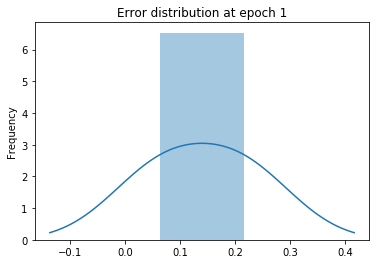

Training error at 100 epoch is 0.005661878269165754


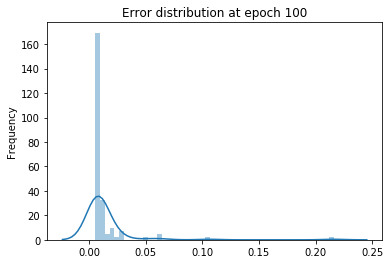

Training error at 200 epoch is 0.004481672775000334


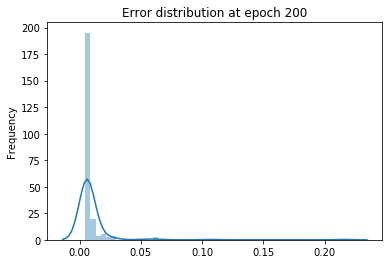

In [650]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
X_train_tensor = torch.Tensor(X_train1.values).float()
Y_train_tensor = torch.Tensor(Y_train1.values).float()

losses_array1 = []

for ep in range(epochs):
    train_prediction = regression_neural_network(X_train_tensor)

    loss = loss_function(train_prediction,Y_train_tensor)
    
    losses_array1.append(loss.item()) # Appending the loss to an array
    
    if ep == 1:
        print("Training error at",ep,"epoch is",losses_array1[ep])
        sns.distplot(losses_array1) # Plotting of the graph
        plt.title("Error distribution at epoch 1")
        plt.ylabel("Frequency")
        plt.savefig('Epoch1.png')
        plt.show()
    
    if ep == 100:
        print("Training error at",ep,"epoch is",losses_array1[ep])
        sns.distplot(losses_array1) # Plotting of the graph
        plt.title("Error distribution at epoch 100")
        plt.ylabel("Frequency")
        plt.savefig('Epoch2.png')
        plt.show()
        
    if ep == 200 :
        print("Training error at",ep,"epoch is",losses_array1[ep])
        sns.distplot(losses_array1) # Plotting of the graph
        plt.title("Error distribution at epoch 200")
        plt.ylabel("Frequency")
        plt.savefig('Epoch3.png')
        plt.show()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

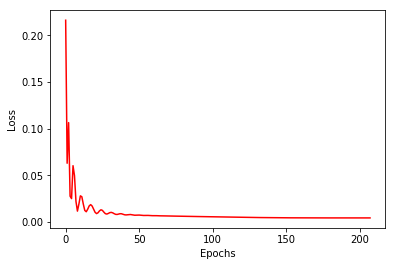

In [651]:
plt.plot(losses_array1,'r')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('loss_array_new.png')

### Encoding

In [703]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
# Reading the csv files
df = pd.read_csv('Comp1111_data_csv.csv')
df = df[2:]
df = df.drop(columns=['Regno','ES'])

# Preprocessing
le = preprocessing.LabelEncoder()
df['Tutgroup'] = le.fit_transform(df['Tutgroup'])
df.reset_index(inplace = True)

le = preprocessing.LabelEncoder()
df['Crse/Prog'] = le.fit_transform(df['Crse/Prog'])
df.reset_index(inplace = True)

#Replacing '.' to zeros
df = df.replace(to_replace= '.' , value = 0)
# String to numeric Conversion
df['S'] = pd.to_numeric(df['S'])
df['lab2'] = pd.to_numeric(df['lab2'])
df['Unnamed: 6'] = pd.to_numeric(df['Unnamed: 6'])
df['lab4'] = pd.to_numeric(df['lab4'])
df['Unnamed: 8'] = pd.to_numeric(df['Unnamed: 8'])
df['h2'] = pd.to_numeric(df['h2'])
df['Unnamed: 10'] = pd.to_numeric(df['Unnamed: 10'])
df['p1'] = pd.to_numeric(df['p1'])
df['Unnamed: 12'] = pd.to_numeric(df['Unnamed: 12'])
df['mid'] = pd.to_numeric(df['mid'])
df['Unnamed: 14'] = pd.to_numeric(df['Unnamed: 14'])
df['final'] = pd.to_numeric(df['final'])

X = df.drop(columns = ['final'])
Y = df[['final']]

# Normalization
X['lab2'] = X['lab2'] / 3
X['Unnamed: 6'] = X['Unnamed: 6'] / 5
X['lab4'] = X['lab4'] / 3
X['Unnamed: 8'] = X['Unnamed: 8'] / 20
X['h2'] = X['h2'] / 20
X['Unnamed: 10'] = X['Unnamed: 10'] / 3
X['p1'] = X['p1'] / 20
X['Unnamed: 12'] = X['Unnamed: 12'] / 20
X['mid'] = X['mid'] / 45
X['Unnamed: 14'] = X['Unnamed: 14'] / 3

Y['final'] = Y['final']/100
X = X.drop(columns = ['level_0','index'])

C:\Users\Prateek\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [704]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.25, random_state=42)
X_train1 = X_train1.reset_index(drop = True)
Y_train1 = Y_train1.reset_index(drop=True)

In [705]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
Training_set_index = X_train1.index
Testing_set_index = Y_train1.index

In [706]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
feature_size = X_train1.shape[1]
hidden_layes = best_hyperparameters[0][1]
hidden_layes_1 = best_hyperparameters[0][2]
learning_rate = best_hyperparameters[0][0]
epochs = best_hyperparameters[0][3]

# Regression class model
class Regression_Net(nn.Module):
    def __init__(self,feature_size, hidden, hidden_1,n_output):
        super(Regression_Net, self).__init__()
        self.layer_1 = nn.Linear(feature_size,hidden)
        self.layer_2 = nn.Linear(hidden, hidden_1)
        self.layer_3 = nn.Linear(hidden_1,n_output)
        
    def forward(self,x):
        fc = self.layer_1(x)
        x = (fc)
        x = (self.layer_2(x))
        output_layer = (self.layer_3(x))
        return output_layer
    
regression_neural_network = Regression_Net(feature_size,hidden_layes,hidden_layes_1,n_output=1)
#optimizer
optimizer = torch.optim.Adam(regression_neural_network.parameters(),lr = learning_rate)
# Loss function
loss_function = nn.MSELoss()

### Applying BDR on the training set

Training error at 0 is 0.778221845626831
Epoch Number 0
Mean error 0.8362492
Standard deviation error 0.280908
Threshold error 0.9767031669616699
Number of data points removed from the dataset at 0 epoch is 34




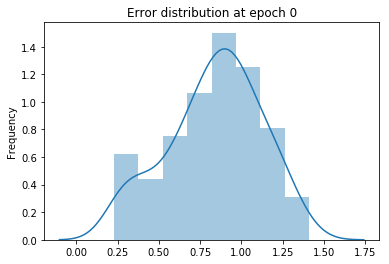

In [707]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
losses_array = []
variance_array = []

for ep in range(epochs):
    new_index = []
    loss_array = []
    X_train_tensor = torch.Tensor(X_train1.values).float()
    Y_train_tensor = torch.Tensor(Y_train1.values).float()
    
    train_prediction = regression_neural_network(X_train_tensor)
    loss = loss_function(train_prediction,Y_train_tensor)
    losses_array.append(loss.item())
    
    if (ep % 100 == 0) :
        loss_array = (Y_train_tensor - train_prediction).detach().numpy()
        loss_array = np.abs(loss_array)
        variance = np.var(loss_array)
        variance_array.append(variance)
        if variance <= 0.01:
             break
        else:
            mean_error = np.mean(loss_array)
            standard_error = np.std(loss_array)
            threshold_error = mean_error + 0.5*standard_error
            print("Training error at",ep,"is",losses_array[-1])
            print("Epoch Number",ep)
            print("Mean error",mean_error)
            print("Standard deviation error",standard_error)
            print("Threshold error",threshold_error)
            
            for t in range(len(loss_array)):
                if (loss_array[t] >= threshold_error):
                    new_index.append(t)
                    
        X_train1 = X_train1.drop(new_index)
        X_train1 = X_train1.reset_index(drop = True)
        Y_train1 = Y_train1.drop(new_index)
        Y_train1 = Y_train1.reset_index(drop = True)
        print("Number of data points removed from the dataset at",ep, "epoch is",len(new_index))
        print("\n")
        sns.distplot(loss_array) # Plotting of the graph
        plt.title("Error distribution at epoch "+ str(ep))
        plt.ylabel("Frequency")
        plt.savefig('BDR_epoch0.png')
        plt.show()
 
        
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

### Testing of the model

In [708]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
test_prediction = regression_neural_network(X_test1_tensor)
loss_on_test_data = loss_function(test_prediction,Y_test1_tensor)
print('test loss: %f' % loss_on_test_data.item())

test loss: 0.011270


### Error graph between the feed forward neural network and the feed forward neural network with BDR algorithm applied

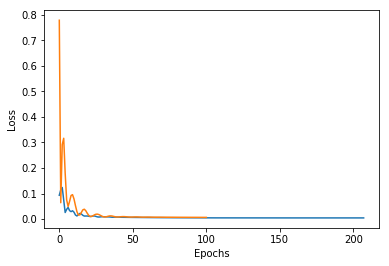

In [710]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
plt.plot(losses_array1)
plt.plot(losses_array)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('loss_fn.png')
plt.show()

## Applying BDR on dataset intially and then applying train and test on that dataset

### Applying BDR

### Encoding

In [719]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
# Reading the csv files
df = pd.read_csv('Comp1111_data_csv.csv')
df = df[2:]
df = df.drop(columns=['Regno','ES'])

# Preprocessing
le = preprocessing.LabelEncoder()
df['Tutgroup'] = le.fit_transform(df['Tutgroup'])
df.reset_index(inplace = True)

le = preprocessing.LabelEncoder()
df['Crse/Prog'] = le.fit_transform(df['Crse/Prog'])
df.reset_index(inplace = True)

#Replacing '.' to zeros
df = df.replace(to_replace= '.' , value = 0)
# String to numeric Conversion
df['S'] = pd.to_numeric(df['S'])
df['lab2'] = pd.to_numeric(df['lab2'])
df['Unnamed: 6'] = pd.to_numeric(df['Unnamed: 6'])
df['lab4'] = pd.to_numeric(df['lab4'])
df['Unnamed: 8'] = pd.to_numeric(df['Unnamed: 8'])
df['h2'] = pd.to_numeric(df['h2'])
df['Unnamed: 10'] = pd.to_numeric(df['Unnamed: 10'])
df['p1'] = pd.to_numeric(df['p1'])
df['Unnamed: 12'] = pd.to_numeric(df['Unnamed: 12'])
df['mid'] = pd.to_numeric(df['mid'])
df['Unnamed: 14'] = pd.to_numeric(df['Unnamed: 14'])
df['final'] = pd.to_numeric(df['final'])

X = df.drop(columns = ['final'])
Y = df[['final']]

# Normalization
X['lab2'] = X['lab2'] / 3
X['Unnamed: 6'] = X['Unnamed: 6'] / 5
X['lab4'] = X['lab4'] / 3
X['Unnamed: 8'] = X['Unnamed: 8'] / 20
X['h2'] = X['h2'] / 20
X['Unnamed: 10'] = X['Unnamed: 10'] / 3
X['p1'] = X['p1'] / 20
X['Unnamed: 12'] = X['Unnamed: 12'] / 20
X['mid'] = X['mid'] / 45
X['Unnamed: 14'] = X['Unnamed: 14'] / 3

Y['final'] = Y['final']/100
X = X.drop(columns = ['level_0','index'])

C:\Users\Prateek\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [720]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
X_train1,Y_train1 = X,Y

In [721]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
feature_size = X_train1.shape[1]
hidden_layes = best_hyperparameters[0][1]
hidden_layes_1 = best_hyperparameters[0][2]
learning_rate = best_hyperparameters[0][0]
epochs = best_hyperparameters[0][3]

# Regression class model
class Regression_Net(nn.Module):
    def __init__(self,feature_size, hidden, hidden_1,n_output):
        super(Regression_Net, self).__init__()
        self.layer_1 = nn.Linear(feature_size,hidden)
        self.layer_2 = nn.Linear(hidden, hidden_1)
        self.layer_3 = nn.Linear(hidden_1,n_output)
        
    def forward(self,x):
        fc = self.layer_1(x)
        x = (fc)
        x = (self.layer_2(x))
        output_layer = (self.layer_3(x))
        return output_layer
    
regression_neural_network = Regression_Net(feature_size,hidden_layes,hidden_layes_1,n_output=1)
#optimizer
optimizer = torch.optim.Adam(regression_neural_network.parameters(),lr = learning_rate)
# Loss function
loss_function = nn.MSELoss()

### Applying the BDR algorithm

Training error at 0 is 0.231109619140625
Epoch Number 0
Mean error 0.38333935
Standard deviation error 0.29010442
Threshold error 0.49938111305236815
Number of data points removed from the dataset at 0 epoch is 50




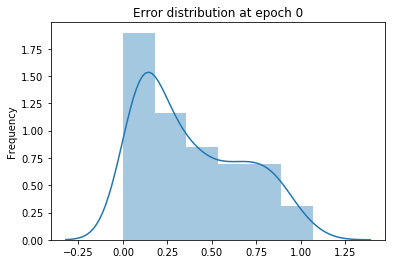

In [722]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
losses_array = []
variance_array = []

for ep in range(epochs):
    new_index = []
    loss_array = []
    X_train_tensor = torch.Tensor(X_train1.values).float()
    Y_train_tensor = torch.Tensor(Y_train1.values).float()
    
    train_prediction = regression_neural_network(X_train_tensor)
    loss = loss_function(train_prediction,Y_train_tensor)
    losses_array.append(loss.item())
    
    if (ep % 100 == 0) :
        loss_array = (Y_train_tensor - train_prediction).detach().numpy()
        loss_array = np.abs(loss_array)
        variance = np.var(loss_array)
        variance_array.append(variance)
        if variance <= 0.01:
             break
        else:
            mean_error = np.mean(loss_array)
            standard_error = np.std(loss_array)
            threshold_error = mean_error + 0.4*standard_error
            print("Training error at",ep,"is",losses_array[-1])
            print("Epoch Number",ep)
            print("Mean error",mean_error)
            print("Standard deviation error",standard_error)
            print("Threshold error",threshold_error)
            
            for t in range(len(loss_array)):
                if (loss_array[t] >= threshold_error):
                    new_index.append(t)
                    
        X_train1 = X_train1.drop(new_index)
        X_train1 = X_train1.reset_index(drop = True)
        Y_train1 = Y_train1.drop(new_index)
        Y_train1 = Y_train1.reset_index(drop = True)
        print("Number of data points removed from the dataset at",ep, "epoch is",len(new_index))
        print("\n")
        sns.distplot(loss_array) # Plotting of the graph
        plt.title("Error distribution at epoch "+ str(ep))
        plt.ylabel("Frequency")
        plt.savefig('BDR_full.png')
        plt.show()
 
        
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

#### Now applying Neural network on the new dataset after removing the dataset using BDR algorithm

In [723]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
X_neural_train, X_neural_test, Y_neural_train, Y_neural_test = train_test_split(X_train1, Y_train1, test_size= 0.2, random_state=42)
X_test1_tensor = torch.Tensor(X_neural_test.values).float()
Y_test1_tensor = torch.Tensor(Y_neural_test.values).float()

In [724]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
feature_size = X_train1.shape[1]
hidden_layes = best_hyperparameters[0][1]
hidden_layes_1 = best_hyperparameters[0][2]
learning_rate = best_hyperparameters[0][0]
epochs = best_hyperparameters[0][3]

# Regression class model
class Regression_Net(nn.Module):
    def __init__(self,feature_size, hidden, hidden_1,n_output):
        super(Regression_Net, self).__init__()
        self.layer_1 = nn.Linear(feature_size,hidden)
        self.layer_2 = nn.Linear(hidden, hidden_1)
        self.layer_3 = nn.Linear(hidden_1,n_output)
        
    def forward(self,x):
        fc = self.layer_1(x)
        x = (fc)
        x = (self.layer_2(x))
        output_layer = (self.layer_3(x))
        return output_layer
    
regression_neural_network = Regression_Net(feature_size,hidden_layes,hidden_layes_1,n_output=1)
#optimizer
optimizer = torch.optim.Adam(regression_neural_network.parameters(),lr = learning_rate)
# Loss function
loss_function = nn.MSELoss()

#### Training of the model

In [725]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
X_train_tensor = torch.Tensor(X_neural_train.values).float()
Y_train_tensor = torch.Tensor(Y_neural_train.values).float()

losses_array1 = []

for ep in range(epochs):
    train_prediction = regression_neural_network(X_train_tensor)

    loss = loss_function(train_prediction,Y_train_tensor)
    
    losses_array1.append(loss.item())
    
    if ep % 50 == 0 :
        print("Training error at",ep,"is",losses_array1[ep])

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    

Training error at 0 is 0.29303449392318726
Training error at 50 is 0.011268800124526024
Training error at 100 is 0.007091884966939688
Training error at 150 is 0.005727490875869989
Training error at 200 is 0.004625499714165926


#### Testing of the model

In [726]:
# Reference - Most of the coding is taken or inspired from the lab 3 solutions in which regression model is been implemented
test_prediction = regression_neural_network(X_test1_tensor)
loss_on_test_data = loss_function(test_prediction,Y_test1_tensor)
print('test loss: %f' % loss_on_test_data.item())

test loss: 0.006380
